In [1039]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import StudentT
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import math
from scipy.stats import norm
from collections import defaultdict
from random import uniform
from tqdm import tqdm
import scipy.stats
from scipy.integrate import quad

In [1040]:
class SpatioTemporalCausalAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_assets, num_timesteps):
        super().__init__()
        self.embed = nn.Linear(input_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.output_proj = nn.Linear(embed_dim, embed_dim)
        self.num_assets = num_assets
        self.num_timesteps = num_timesteps

        # Precompute causal time mask
        t = num_timesteps
        a = num_assets
        time_ids = torch.arange(t).repeat(a)  # [A*T]
        mask = time_ids[None, :] <= time_ids[:, None]
        self.register_buffer("causal_mask", (~mask).float() * float('-inf'))  # [A*T, A*T]

    def forward(self, x):
        B, A, T, V = x.shape
        x = x.permute(0, 2, 1, 3).reshape(B, A*T, V)  # [B, A*T, V]
        x = self.embed(x)
    
        # Recreate the mask dynamically in case T is variable
        time_ids = torch.arange(T, device=x.device).repeat(A)
        mask = time_ids[None, :] <= time_ids[:, None]
        causal_mask = (~mask).float() * float('-1e9')  # [A*T, A*T]
    
        attn_out, _ = self.attn(x, x, x, attn_mask=causal_mask)
        x_proj = self.output_proj(attn_out)
        
        return x_proj.reshape(B, T, A, -1).permute(0, 2, 1, 3)  # [B, A, T, E]

In [1041]:
class MultiTimescaleLSTM(nn.Module):
    def __init__(self, asset_size, h_size, n_layers, batch_size, seq_len,
                 pre_heads, time_heads, asset_heads, num_studentT,
                 value_size, dropout=0.0):
        super().__init__()

        self.asset_out_size = asset_size
        self.value_size = value_size
        self.h_size = h_size
        self.seq_len = seq_len
        self.num_studentT = num_studentT

        # === Attention Modules ===
        self.spatio_temporal_attn = SpatioTemporalCausalAttention(
            input_dim=value_size,
            embed_dim=h_size,
            num_heads=pre_heads,
            num_assets=asset_size,
            num_timesteps=seq_len
        )

        self.temporal_attn = nn.MultiheadAttention(embed_dim=h_size, num_heads=time_heads, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=h_size, num_heads=asset_heads, batch_first=True)

        # === LSTM ===
        self.lstm = nn.LSTM(
            #input_size=asset_size * h_size,
            input_size=asset_size * value_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )

        # === Linear Layers ===
        self.post_fc = nn.Linear(asset_size * h_size, 4 * asset_size * num_studentT)

    def forward(self, x):
        """
        x: [B, A, V, T]
        """
        B, A, V, T = x.shape
        H = self.h_size
        #x = x.transpose(2, 3)  # -> [B, A, T, V]

        # === Spatio-Temporal Attention ===
        #x_attn = self.spatio_temporal_attn(x)  # [B, A, T, H]
        #x_attn = x_attn.transpose(1, 2)          # [B, T, A, H]
        #B, T, A, H = x_attn.shape
        #x_flat = x_attn.reshape(B, T, A * H)     # [B, T, A*H]
        x = x.transpose(1, 3)
        x_flat = x.reshape(B, T, A*V)

        # === LSTM ===
        lstm_out, _ = self.lstm(x_flat)          # [B, T, H]

        # === Temporal Attention with Causal Mask ===
        device = lstm_out.device
        causal_mask = torch.triu(torch.full((T, T), float('-inf')), diagonal=1).to(device)
        temp_out, _ = self.temporal_attn(lstm_out, lstm_out, lstm_out, attn_mask=causal_mask)

        # === Cross-Asset Attention ===
        final_state = temp_out[:, -1, :]                  # [B, H]
        expanded = final_state.unsqueeze(1).repeat(1, A, 1)  # [B, A, H]
        asset_out, _ = self.cross_attn(expanded, expanded, expanded)  # [B, A, H]
        asset_flat = asset_out.reshape(B, A * H)          # [B, A*H]

        final = self.post_fc(asset_flat) # [B, A*5]
        final = final.view(B, A, 4, self.num_studentT)

        # === Output Parameters ===
        # [B, A, K]
        mu       = final[:, :, 0, :]
        log_sigma = final[:, :, 1, :]
        log_nu    = final[:, :, 2, :]
        dist_weights = final[:, :, 3, :]

        sigma = torch.exp(log_sigma) + 1e-2
        nu = torch.exp(log_nu) + 2.0
        dist_weights = torch.softmax(dist_weights, dim=-1)

        return mu, sigma, nu, dist_weights

In [1042]:
def mixture_student_t_logpdf(x, mus, sigmas, nus, dist_weights):
    """
    Log-likelihood of Mixture of Student-t Distributions.

    Inputs:
        x:        [B, A]         target returns
        mus:      [B, A, K]      mixture component means
        sigmas:   [B, A, K]      std deviations (must be positive)
        nus:      [B, A, K]      degrees of freedom (must be > 2)
        weights:  [B, A, K]      unnormalized weights

    Returns:
        log_prob: [B, A]         log-likelihood of each sample
    """
    x = x.unsqueeze(-1).expand_as(mus)  # [B, A, K]
    t_dist = StudentT(loc=mus, scale=sigmas, df=nus)
    log_pdf = t_dist.log_prob(x)  # [B, A, K]
    log_w = F.log_softmax(dist_weights, dim=-1)  # [B, A, K]
    return torch.logsumexp(log_pdf + log_w, dim=-1)  # [B, A]


"""
# Define evaluation points from 0 to 10
x = torch.linspace(-1, 1, 1000)  # shape [1000]

mu = torch.zeros_like(x) + 0.13
sig = torch.zeros_like(x) + 0.35
nu = torch.zeros_like(x) + 3.45
dist_weights = torch.zeros_like(x) + 3.45

# Compute log-PDF and exponentiate
log_pdf = mixture_student_t_logpdf(x, mu, sig, nu, dist_weights)
pdf = torch.exp(log_pdf)

# Numerical integration over [0, 10]
area = torch.trapz(pdf, x)
print("Integral over [0, 10]:", area.item())

# Plot
plt.plot(x, pdf)
plt.title("PDF on [0, 10]")
plt.grid()
plt.show()
"""

'\n# Define evaluation points from 0 to 10\nx = torch.linspace(-1, 1, 1000)  # shape [1000]\n\nmu = torch.zeros_like(x) + 0.13\nsig = torch.zeros_like(x) + 0.35\nnu = torch.zeros_like(x) + 3.45\ndist_weights = torch.zeros_like(x) + 3.45\n\n# Compute log-PDF and exponentiate\nlog_pdf = mixture_student_t_logpdf(x, mu, sig, nu, dist_weights)\npdf = torch.exp(log_pdf)\n\n# Numerical integration over [0, 10]\narea = torch.trapz(pdf, x)\nprint("Integral over [0, 10]:", area.item())\n\n# Plot\nplt.plot(x, pdf)\nplt.title("PDF on [0, 10]")\nplt.grid()\nplt.show()\n'

In [1043]:
def mixture_student_t_loss(mu, sigma, nu, dist_weights, target, deviation=(100., 0.)):

    # Dont punish the network for mispredicting unpredictable targets
    #target = torch.where(((torch.abs(target) < deviation[0]) & (torch.abs(target) > deviation[1])), target, 0.0)

    logp = mixture_student_t_logpdf(target, mu, sigma, nu, dist_weights)
    pdf_loss = -logp.mean()
        
    #sigma_penalty = torch.mean(1.0 / sigma)  # penalize tiny sigma

    # Encourage the network to use all student t distributions
    weight_entropy = -((1 / dist_weights) * dist_weights.log()).sum(dim=-1).mean()

    loss = pdf_loss + weight_entropy * 0.1
    
    return loss.mean()

In [1044]:
class StockDataset():
    def __init__(self, root_dir, seq_len=1024):
        self.seq_len = seq_len
        self.root_dir = root_dir
        self.files = self.get_filenames()
        self.data = self.load_data()

    def get_filenames(self):
        files = os.listdir(self.root_dir)
        return files
    
    def load_data(self):
        # Array of dimension [stock name, price category(open, close, high, low, close, volume, date), sequence length]
        data = np.zeros((len(self.files), 7, self.seq_len))
        
        for i, filename in enumerate(self.files):
            
            with open(self.root_dir + '/' + filename, 'r', encoding="utf-8") as file:
                #print(filename)
                #head = file.read(1000)
                #print(head)  # if this looks binary, it's not a JSON file!
                file.seek(0)
                content = json.load(file)
                time_series = content["Time Series (Daily)"]

                df = pd.DataFrame.from_dict(time_series, orient='index')
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df.index = pd.to_datetime(df.index)
                df = df.apply(pd.to_numeric, errors='coerce')

                o = df[['open']].to_numpy()
                c = df[['close']].to_numpy()
                h = df[['high']].to_numpy()
                l = df[['low']].to_numpy()
                v = df[['volume']].to_numpy()
                t = df.index.to_numpy()

                # All data is aranged from oldest to newest date
                # So we first have to flip the data by [::-1]
                data[i, 0, :] = o.flatten()[:self.seq_len][::-1] / o.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 1, :] = c.flatten()[:self.seq_len][::-1] / c.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 2, :] = h.flatten()[:self.seq_len][::-1] / h.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 3, :] = l.flatten()[:self.seq_len][::-1] / l.flatten()[1:self.seq_len + 1][::-1] - 1
                data[i, 5, :] = v.flatten()[:self.seq_len][::-1] / v.flatten()[self.seq_len + 1]

                # convert date to unix time
                dates = t.flatten()[:self.seq_len][::-1]
                data[i, 6, :] = dates.astype('datetime64[s]')
                data[i, 6, :] = data[i, 6, :].astype('int64')

                file.close()

            # extra statistics
            data[:, 4, :] = data[:, 2, :] - data[:, 3, :] # daily range high - low
    
        return data

    def scale_log(self):
        self.data = np.log(1 + self.data)
        return 0

    def average(self, decay_fac=0.0):
        
        avg_arr = np.zeros_like(self.data)
        
        for i in range(self.seq_len):
            exp_decay = np.exp(-decay_fac * np.arange(0, self.seq_len - i))
            exp_decay = exp_decay[::-1]
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.expand_dims(exp_decay, axis=0)
            exp_decay = np.repeat(exp_decay, repeats=len(self.files), axis=0)
            exp_decay = np.repeat(exp_decay, repeats=5, axis=1)
            avg_arr[:,:-1,i] = np.sum(self.data[:,:-1,i:] * exp_decay, axis=-1) / np.sum(exp_decay[:,:,:], axis=-1)
        
        avg_arr[:,-1,:] = self.data[:,-1,:].copy()

        return avg_arr

    def recons_absol(self):
        # this function only provides a test to reconstruct the original shape of the stock prices
        abs_data = np.zeros_like(self.data)
        abs_data[:,:,0] = 1.
        abs_data[:,-1,:] = self.data[:,-1,:]
        # iterate over all timesteps after the first
        for j in range(self.data.shape[2] - 1):
            abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])

        return abs_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

['LMT.json', 'BMW.DE.json', 'FRE.DE.json', 'ENR.DE.json', 'DAI.DE.json', 'SAP.DE.json', 'DHER.DE.json', 'AAPL.json', 'HOT.DE.json', 'RHM.DE.json', 'BAYN.DE.json', 'MUV2.DE.json', 'BAS.DE.json', 'ADS.DE.json', 'DBK.DE.json', 'ALV.DE.json', 'SIE.DE.json', 'DTE.DE.json']


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_63232/2628515410.py:86: RuntimeWarning: overflow encountered in multiply
  abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])


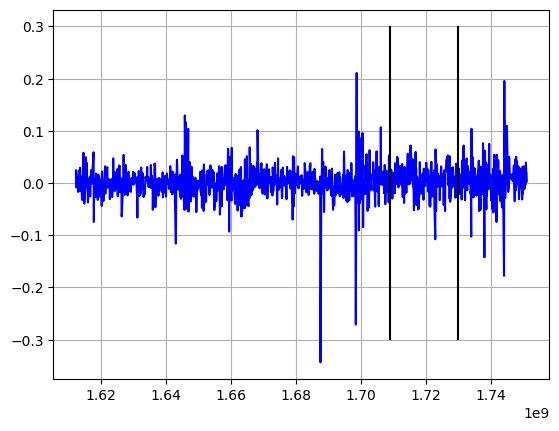

In [1045]:
#root_dir = "/Users/silas/work/machine_learning/LSTM/data/data_dump"
root_dir = "/Users/silas/work/machine_learning/LSTM/data/my_repo"
stock_data = StockDataset(root_dir, seq_len=1124)
#stock_data.scale_log()

stock_nr = 3

print(stock_data.files)
#plt.plot(stock_data.data[stock_nr,-1,:], stock_data.data[stock_nr,0,:])

abs_data = stock_data.recons_absol()
x = abs_data[stock_nr,-1,:]
y = np.mean(abs_data[:,0,:], axis=0)

y = stock_data.data[stock_nr,0,:]

log_y = np.log(1 + y)

plt.plot(x, y, color="blue")
#plt.plot(x, log_y, color="red")
plt.grid()
val_cut = x[int(0.7*len(x))]
test_cut = x[int(0.85*len(x))]
plt.vlines([val_cut, test_cut], -0.3, 0.3, color="black")
plt.show()

In [1046]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_stock_idx, max_deviation=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len
        self.max_deviation = max_deviation

    def __len__(self):
        return self.data.shape[-1] - self.seq_len

    def __getitem__(self, idx):
        x = self.data[:, :, idx : idx + self.seq_len]
        # Mask input data !!! Not Target !!!
        if self.max_deviation != False:
            x = torch.where(torch.abs(x) > self.max_deviation, 0.0, x)
        y = self.data[:, target_stock_idx, idx + self.seq_len]
        return x, y

In [1047]:
def split_time_series(data, train_ratio=0.7, val_ratio=0.15):
    time_steps = data.shape[-1]
    #print(f"Time steps: {time_steps}")
    train_end = int(time_steps * train_ratio)
    val_end = int(time_steps * (train_ratio + val_ratio))
    return data[:, :, 0:train_end], data[:, :, train_end:val_end], data[:, :, val_end:]

In [1048]:
def get_warmup_cosine_scheduler(optimizer, warmup_steps, total_steps, lr_max):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        else:
            progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

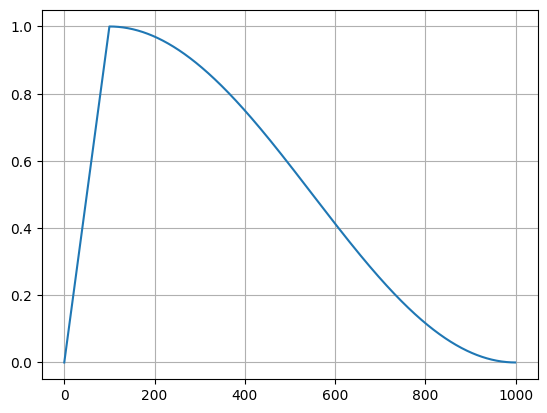

In [1049]:
dummy_warmup_steps = 100
dummy_total_steps = 1000
dummy_lr = np.zeros(dummy_total_steps)
dummy_steps = np.arange(0, dummy_total_steps, 1)

for step in dummy_steps:
    if step < dummy_warmup_steps:
        dummy_lr[step] = step / dummy_warmup_steps
    else:
        progress = (step - dummy_warmup_steps) / (dummy_total_steps - dummy_warmup_steps)
        dummy_lr[step] = 0.5 * (1 + math.cos(math.pi * progress))

plt.plot(dummy_steps, dummy_lr)
plt.grid()
plt.show()

In [1050]:
# lstm model parameters
h_size = 16
n_layers = 3
num_studentT = 3

pre_heads = 2
time_heads = 2
asset_heads = 2

dropout = 0.5
seq_len = 16
batch_size = 1
deviation = (100.00, 0.0) # target deviation in loss function

# training lstm model
warmup_steps = 20
total_steps = 120
lr_max=5e-6
weight_decay = 1e-6
momentum = 0.9

In [1051]:
in_size = len(stock_data.files) # number of stocks
data = stock_data.data[:,:5,:] # Pass only OHLC, not V
target_stock_idx = 1 # [open, close, high, low, volume, datetime]

print(f"Stock dimension: {stock_data.data.shape}")
value_size = data_pass.shape[1]
print(f"Value size: {value_size}")

Stock dimension: (18, 7, 1124)
Value size: 5


In [1052]:
train_ratio = 0.7
val_ratio = 0.15
max_deviation = 0.05 # Mask extreme data

###############
#### Data #####
###############
train, val, test = split_time_series(train_data, train_ratio=train_ratio, val_ratio=val_ratio)
print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

train_ds = TimeSeriesDataset(train, seq_len, target_stock_idx, max_deviation)
val_ds = TimeSeriesDataset(val, seq_len, target_stock_idx, max_deviation)
test_ds = TimeSeriesDataset(test, seq_len, target_stock_idx, max_deviation)
#print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

# (Batch, in_size, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Shapes: train=(18, 5, 786) val=(18, 5, 169) test=(18, 5, 169)


In [1053]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"device: {device}")

device: cpu


In [1054]:
model = MultiTimescaleLSTM(in_size, h_size, n_layers, batch_size, seq_len, pre_heads, 
                           time_heads, asset_heads, num_studentT, value_size, dropout).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr_max, weight_decay=weight_decay, momentum=momentum)
scheduler = get_warmup_cosine_scheduler(optimizer, warmup_steps=warmup_steps, total_steps=total_steps, lr_max=lr_max)

In [1055]:
def calc_correct_preds(test_data, mu, sigma, nu, dist_weights, threshold):

    sigma = np.where(nu > 2, np.sqrt(nu / (nu-2)) * sigma, 1e10)
    
    # signal to noise ratio
    s_n = np.abs(mu) / sigma

    significant_out = np.where(s_n > threshold, np.where(mu > 0, 1, -1), 0.)

    samples = np.sum((significant_out * test_data) != 0)
    correct_sign = np.sum((significant_out * test_data) > 0.)

    return samples, correct_sign

In [1056]:
def calc_alloc_return(
    mu, sigma, nu, dist_weights, real_returns,
    cash_threshold=0.3,
    temp=1.0,
    apply_confidence_mask=True,
    min_prob=0.1,
    max_loss=0.05,
    invest_sigmoid_scale=10.0,
    allow_short=True
):
    B, A, K = mu.shape
    device = mu.device

    # Add 'cash' asset
    mu = torch.cat([mu, torch.zeros(B, 1, K, device=device)], dim=1)
    sigma = torch.cat([sigma, torch.ones(B, 1, K, device=device)], dim=1)
    nu = torch.cat([nu, torch.full((B, 1, K), 10.0, device=device)], dim=1)
    dist_weights = torch.cat([dist_weights, torch.full((B, 1, K), 1e-9, device=device)], dim=1)
    real_returns = torch.cat([real_returns, torch.zeros(B, 1, device=device)], dim=1)

    def mix_pdf(x_grid):
        x = x_grid[:, None, None, None]  # [X, 1, 1, 1]
        dist = StudentT(loc=mu[None], scale=sigma[None], df=nu[None])
        pdf = dist.log_prob(x).exp()
        return (dist_weights[None] * pdf).sum(dim=-1)  # [X, B, A+1]

    def integrate(x, y):
        return torch.trapz(y, x, dim=0)

    x_grid = torch.linspace(-10, 10, 10000, device=device)
    pdf = mix_pdf(x_grid)
    pos_prob = integrate(x_grid, pdf * (x_grid > 0).float()[:, None, None])
    exp_gain = integrate(x_grid, pdf * x_grid[:, None, None])

    x_loss = torch.linspace(-10, -float(max_loss), 10000, device=device)
    pdf_loss = mix_pdf(x_loss)
    loss_prob = integrate(x_loss, pdf_loss)

    pos_prob[:, -1] = cash_threshold
    if apply_confidence_mask:
        #min_prob = min_prob.view(-1, 1)
        pos_prob *= (pos_prob.abs() > min_prob).float()
    #pos_prob *= (loss_prob < max_loss).float()

    alloc_raw = F.softmax(pos_prob / temp, dim=-1)
    mu_mean = mu.mean(dim=2)
    max_sig = pos_prob[:, :-1].max(dim=1, keepdim=True)[0]
    invest_ratio = torch.sigmoid((max_sig - cash_threshold) * invest_sigmoid_scale)
    allocations = alloc_raw * invest_ratio

    returns = torch.where(mu_mean > 0, real_returns, -real_returns) if allow_short else real_returns * (mu_mean > 0).float()
    port_ret = (allocations * returns).sum(dim=1)
    return allocations, port_ret

In [1057]:
train_cash_threshold = 0.05
train_temp = 0.01
train_min_prob = 0.01
train_max_loss = 0.05
train_invest_sigmoid_scale = 5

# Train LSTM model
for step in range(total_steps):
    
    # Training
    model.train()
    train_loss = 0
    
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # train stock predictor
        optimizer.zero_grad()
        mu, sigma, nu, dist_weights = model(batch_x)
        loss = mixture_student_t_loss(mu, sigma, nu, dist_weights, batch_y, deviation)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    if (step % 5 == 4):
        model.eval()
        val_loss = 0

        all_returns = []
        total_ret, sample_count = 0, 0
    
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
    
            mu, sigma, nu, dist_weights = model(val_x)
            loss = mixture_student_t_loss(mu, sigma, nu, dist_weights, val_y, deviation)
    
            val_loss += loss.item()
    
            # === Apply current threshold to get allocation and returns ===
            alloc, port_ret = calc_alloc_return(
                mu, sigma, nu, dist_weights, val_y,
                cash_threshold=train_cash_threshold,
                temp=train_temp,
                apply_confidence_mask=True,
                min_prob=train_min_prob,
                max_loss=train_max_loss,
                invest_sigmoid_scale=train_invest_sigmoid_scale,
                allow_short=True
            )
        
            total_ret += port_ret.sum().item()
            sample_count += port_ret.shape[0]
        
            all_returns.extend(port_ret.detach().cpu().numpy().flatten())

        """
        print("Weights: ", dist_weights)
        print("mu: ", mu)
        print("sigma: ", sigma)
        print("nu: ", nu)
        """
            
        avg_daily_ret = total_ret / sample_count
        annual_ret = ((avg_daily_ret + 1)**252 - 1) * 100  # Trading year ≈ 252 days
    
        # Convert to numpy array
        all_returns = np.array(all_returns)  # shape: [n_days]
        
        # Cumulative equity (compound growth)
        equity_curve = np.cumprod(1 + all_returns)
        
        # Annualized return
        annualized_return = (equity_curve[-1]) ** (252 / len(equity_curve)) - 1
        
        # Sharpe ratio (assume 0% risk-free rate)
        sharpe_ratio = np.mean(all_returns) / (np.std(all_returns) + 1e-8) * np.sqrt(252)
        
        # Max drawdown
        rolling_max = np.maximum.accumulate(equity_curve)
        drawdowns = (equity_curve - rolling_max) / rolling_max
        max_drawdown = drawdowns.min()

        avg_val_loss = val_loss / len(val_loader)

        print(f"<========== Training metrics ==========>")
        print(f"Step              : {step+1}/{total_steps}")
        print(f"LR in millions    : {scheduler.get_last_lr()[0]*10e6:.3f}")
        print(f"Train Loss        : {avg_train_loss:.4f}")
        print(f"Validation Loss   : {avg_val_loss:.4f}")
        print(f"<========== Quick Validation set Performance ==========>")
        print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
        print(f"Annualized return: {annualized_return:.2%}")
        print(f"Sharpe ratio: {sharpe_ratio:.2f}")
        print(f"Max drawdown: {max_drawdown:.2%}")
        print(f"mu: {mu.mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
        print(f"sigma: {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
        print(f"nu: {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
        print(f"Weights: {dist_weights.mean():.4f} [{dist_weights.min():.4f}, {dist_weights.max():.4f}]")
        #print(f"Weights: {dist_weights.item():.2f}")
        #print(f"Significant points: {samples}")
        print()

Step              : 5/120
LR in millions    : 12.500
Train Loss        : 2.0080
Validation Loss   : 2.0078
<========== Quick Validation set Performance ==========>
Final cumulative return: 2.63%
Annualized return: 4.37%
Sharpe ratio: 0.68
Max drawdown: -5.52%
mu: -0.0019 [-0.0727, 0.0715]
sigma: 1.0165 [0.9504, 1.0832]
nu: 2.9993 [2.9300, 3.0701]
Weights: 0.3333 [0.3053, 0.3496]

Step              : 10/120
LR in millions    : 25.000
Train Loss        : 2.0062
Validation Loss   : 2.0059
<========== Quick Validation set Performance ==========>
Final cumulative return: -3.00%
Annualized return: -4.89%
Sharpe ratio: -0.83
Max drawdown: -5.19%
mu: -0.0020 [-0.0731, 0.0714]
sigma: 1.0146 [0.9496, 1.0816]
nu: 2.9995 [2.9309, 3.0690]
Weights: 0.3333 [0.3059, 0.3494]

Step              : 15/120
LR in millions    : 37.500
Train Loss        : 2.0031
Validation Loss   : 2.0027
<========== Quick Validation set Performance ==========>
Final cumulative return: -2.86%
Annualized return: -4.67%
Sharpe 

In [1068]:
# Now train the model after evaluating step by step
lr = 5e-6
weight_decay = 0.0 #1e-6
momentum = 0.9

all_returns = []
total_ret, sample_count = 0, 0

train_loss = 0

# Adapt optimizer parameters
optimizer.param_groups[0]['lr'] = lr
optimizer.param_groups[0]['weight_decay'] = weight_decay
optimizer.param_groups[0]['momentum'] = momentum

for batch_x, batch_y in test_loader:

    ######################
    ### first evaluate ###
    ######################
    model.eval()

    mu, sigma, nu, dist_weights = model(batch_x)

    alloc, port_ret = calc_alloc_return(
            mu, sigma, nu, dist_weights, batch_y,
            cash_threshold=train_cash_threshold,
            temp=train_temp,
            apply_confidence_mask=True,
            min_prob=train_min_prob,
            max_loss=train_max_loss,
            invest_sigmoid_scale=train_invest_sigmoid_scale,
            allow_short=True
        )

    total_ret += port_ret.sum().item()
    sample_count += port_ret.shape[0]
    
    all_returns.extend(port_ret.detach().cpu().numpy().flatten())

    ##################
    ### Then train ###
    ##################
    model.train()

    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    # train stock predictor
    optimizer.zero_grad()
    mu, sigma, nu, dist_weights = model(batch_x)
    loss = mixture_student_t_loss(mu, sigma, nu, dist_weights, batch_y, deviation)

    train_loss += loss.item()

    loss.backward()
    optimizer.step()

avg_train_loss = train_loss / len(val_loader)

# Convert to numpy array
all_returns = np.array(all_returns)  # shape: [n_days]

# Cumulative equity (compound growth)
equity_curve = np.cumprod(1 + all_returns)

# Annualized return
annualized_return = (equity_curve[-1]) ** (252 / len(equity_curve)) - 1

# Sharpe ratio (assume 0% risk-free rate)
sharpe_ratio = np.mean(all_returns) / (np.std(all_returns) + 1e-8) * np.sqrt(252)

# Max drawdown
rolling_max = np.maximum.accumulate(equity_curve)
drawdowns = (equity_curve - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

print(f"<========== Online Learaning Performance ==========>")
print(f"Loss                   : {avg_train_loss:.4f}")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return: {annualized_return:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")
print(f"mu: {mu.mean():.4f} [{mu.min():.4f}, {mu.max():.4f}]")
print(f"sigma: {sigma.mean():.4f} [{sigma.min():.4f}, {sigma.max():.4f}]")
print(f"nu: {nu.mean():.4f} [{nu.min():.4f}, {nu.max():.4f}]")
print(f"Weights: {dist_weights.mean():.4f} [{dist_weights.min():.4f}, {dist_weights.max():.4f}]")

<========== Online Learaning Performance ==========>
Loss                   : 1.8848
Final cumulative return: 8.20%
Annualized return: 13.87%
Sharpe ratio: 0.97
Max drawdown: -14.25%
mu: 0.0006 [-0.1422, 0.1282]
sigma: 0.8966 [0.7526, 1.0408]
nu: 3.0022 [2.8308, 3.1611]
Weights: 0.3333 [0.3100, 0.3615]


In [1069]:
def compute_performance_metrics(returns, n_bootstrap=1000, ci=0.95):
    """
    Computes metrics and confidence intervals via bootstrapping.
    Args:
        returns: array-like, daily returns
        n_bootstrap: number of resampling iterations
        ci: confidence level (default: 95%)
    Returns:
        Dict of metric -> (mean, lower_ci, upper_ci)
    """
    returns = np.array(returns)
    alpha = 1 - ci
    metrics = {
        'daily_return': [],
        'cumulative_return': [],
        'annualized_return': [],
        'sharpe_ratio': [],
        'max_drawdown': []
    }

    for _ in range(n_bootstrap):
        sample = np.random.choice(returns, size=len(returns), replace=True)

        # === Metrics ===
        mean_r = np.mean(sample)
        std_r = np.std(sample)
        sharpe = mean_r / (std_r + 1e-8) * np.sqrt(252)

        # Cumulative equity curve
        equity = np.cumprod(1 + sample)
        cum_return = equity[-1] - 1
        annual_ret = (equity[-1])**(252 / len(sample)) - 1

        # Drawdown
        peak = np.maximum.accumulate(equity)
        dd = (equity - peak) / peak
        max_dd = dd.min()

        # Store
        metrics['daily_return'].append(mean_r)
        metrics['cumulative_return'].append(cum_return)
        metrics['annualized_return'].append(annual_ret)
        metrics['sharpe_ratio'].append(sharpe)
        metrics['max_drawdown'].append(max_dd)

    # Compute CI bounds
    def summarize(metric_values):
        mean_val = np.mean(metric_values)
        lower = np.percentile(metric_values, 100 * alpha / 2)
        upper = np.percentile(metric_values, 100 * (1 - alpha / 2))
        return mean_val, lower, upper

    return {k: summarize(v) for k, v in metrics.items()}

In [1070]:
# training allocation model
a_warmup_steps = 20
a_total_steps = 100
a_lr_max=5e-6
a_weight_decay = 0

# Model parameters
hidden_dim = 128
embed_dim = 256
proj_dim = 128
dropout = 0.3

# loss parameters
cash_penalty_factor = 0.0
diversity_penalty_factor = 0.0
entropy_coeff = 0.0

In [1071]:
class allocationModel(nn.Module):
    def __init__(self, in_size, num_studentt, hidden_dim, embed_dim, proj_dim, dropout=0.0):
        super().__init__()
        self.in_size = in_size
        self.input_dim = 4 * in_size * num_studentt
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.proj_dim = proj_dim
        self.pre_layers = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(self.hidden_dim, self.embed_dim)
        )
        self.attn = nn.MultiheadAttention(embed_dim=self.embed_dim, num_heads=4, batch_first=True)
        self.dropout = nn.Dropout(p=dropout)
        self.post_layers = nn.Sequential(
            nn.Linear(self.embed_dim, self.proj_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(self.proj_dim, in_size + 1)
        )

    def forward(self, x):
        # x: [B, A * 4 * num_studentt]
        x = self.pre_layers(x)   # -> [B, A, 32]
        attn_out, _ = self.attn(x, x, x)  # self-attention
        attn_out = nn.LayerNorm(attn_out.shape[-1])(attn_out)
        attn_out = self.dropout(attn_out)
        out = self.post_layers(attn_out)  # -> [B, A, in_size + 1]
        out = torch.softmax(out / 0.01, dim=-1)
        return out

In [1072]:
class RollingSharpeLoss:
    def __init__(self, window_size=100, eps=1e-6, cash_penalty=0.0, diversity_penalty=0.0, entropy_coeff=0.0):
        self.window_size = window_size
        self.returns = []  # buffer
        self.eps = eps
        self.cash_penalty = cash_penalty
        self.diversity_penalty = diversity_penalty

    def __call__(self, weights, target):
        # Compute portfolio return
        port_return = (weights[:, :-1] * target).sum().item()  # scalar

        self.returns.append(port_return)
        if len(self.returns) > self.window_size:
            self.returns.pop(0)

        if len(self.returns) < 2:
            # not enough data to compute Sharpe
            sharpe = 0.0
        else:
            r = torch.tensor(self.returns)
            sharpe = r.mean() / (r.std(unbiased=False) + self.eps)

        # Penalties
        cash_pen = weights[:, -1].mean() * self.cash_penalty
        diversity_pen = (weights[:, :-1] ** 2).sum().mean() * self.diversity_penalty
        entropy = -torch.sum(weights * torch.log(weights + 1e-8), dim=1).mean()

        return -sharpe -entropy_coeff * entropy + cash_pen + diversity_pen

In [1073]:
allocation_model = allocationModel(in_size, num_studentT, hidden_dim, embed_dim, proj_dim, dropout)
allocation_optimizer = torch.optim.Adam(allocation_model.parameters(), lr=a_lr_max, weight_decay=a_weight_decay)
allocation_scheduler = get_warmup_cosine_scheduler(allocation_optimizer, warmup_steps=a_warmup_steps, total_steps=a_total_steps, lr_max=a_lr_max)
allocation_loss = RollingSharpeLoss(window_size=20, eps=1e-6, cash_penalty=cash_penalty_factor, diversity_penalty=diversity_penalty_factor, entropy_coeff=entropy_coeff)

In [1074]:
if 0:
    model.eval()
    for a_step in range(a_total_steps):
        
        # Train model
        allocation_model.train()
    
        val_loss = 0
        for x_val, y_val in train_loader:
            
            mu, sigma, nu, weights = model(x_val) # Each [B, A, K]
            B, A, K = mu.shape
            x = torch.cat([mu, sigma, nu, weights], dim=1) # [B, A * 4, K]
            x = x.reshape(B, A * 4 * K)
            
            output = allocation_model(x)
            loss = allocation_loss(output, y_val)
    
            loss.backward()
            allocation_optimizer.step()
            
            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        allocation_scheduler.step()
    
        # Test performance
        allocation_model.eval()
    
        returns = 0
        test_loss = 0
        for x_test, y_test in val_loader:
    
            mu, sigma, nu, weights = model(x_test) # Each [B, A, K]
            B, A, K = mu.shape
            x = torch.cat([mu, sigma, nu, weights], dim=1) # [B, A * 4, K]
            x = x.reshape(B, A * 4 * K)
            
            output = allocation_model(x)
            loss = allocation_loss(output, y_test)
    
            test_loss += loss.item()
    
            returns += (output[:, :-1] * y_test).sum()
        avg_returns = returns / len(test_loader)
        avg_test_loss = test_loss / len(test_loader)
    
        if (a_step % 10 == 9):
            print(f"Step              : {a_step+1}/{a_total_steps}")
            print(f"LR in millions    : {allocation_scheduler.get_last_lr()[0]*10e6:.3f}")
            print(f"Validation loss   : {avg_val_loss:.5f}")
            print(f"Test loss         : {avg_test_loss:.5f}")
            print(f"Average Day return: {avg_returns * 100:.2}%")
            print(output)
            print()

In [1075]:
########################
####### Analyze ########
########################

def sample_random_params():
    return {
        "cash_threshold": uniform(0.0, 0.05),
        "temp": uniform(0.001, 0.1),
        "min_prob": uniform(0.0, 1.0),
        "max_loss": uniform(0.0, 0.1),
        "invest_sigmoid_scale": uniform(1.0, 20.0)
    }

def evaluate_config(model, val_loader, config):
    all_returns = []
    model.eval()
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            mu, sigma, nu, dist_weights = model(val_x)

            _, port_ret = calc_alloc_return(
                mu, sigma, nu, dist_weights, val_y,
                cash_threshold=config['cash_threshold'],
                temp=config['temp'],
                apply_confidence_mask=True,
                min_prob=config['min_prob'],
                max_loss=config['max_loss'],
                invest_sigmoid_scale=config['invest_sigmoid_scale'],
                allow_short=True
            )

            returns = port_ret.detach().cpu().numpy().flatten()
            all_returns.extend(returns)

    r = np.array(all_returns)
    if len(r) < 10:  # not enough points for reliable metrics
        return None

    # Metrics
    equity = np.cumprod(1 + r)
    cumulative_return = equity[-1] - 1
    annualized = (equity[-1])**(252 / len(r)) - 1
    sharpe = np.mean(r) / (np.std(r) + 1e-8) * np.sqrt(252)
    max_dd = (equity - np.maximum.accumulate(equity)) / np.maximum.accumulate(equity)
    drawdown = max_dd.min()

    return {
        'sharpe': sharpe,
        'annualized_return': annualized,
        'cumulative_return': cumulative_return,
        'max_drawdown': drawdown,
        'samples': len(r),
        'combined': 0.5 * sharpe + 2 * annualized - 1 * abs(drawdown)
    }

if 0:
    n_trials = 500
    results = []
    
    for _ in tqdm(range(n_trials)):
        params = sample_random_params()
        metrics = evaluate_config(model, val_loader, params)
        if metrics:
            results.append({
                **params,
                **metrics
            })

In [1076]:
if 0:
    """
    'sharpe'
    'annualized_return'
    'cumulative_return'
    'max_drawdown'
    'combined'
    """
    
    optimized_by = 'annualized_return'
    
    
    # Sort by Sharpe ratio
    sorted_results = sorted(results, key=lambda x: x[optimized_by], reverse=True)
    
    # Best configuration
    top_k = 10
    top_configs = sorted_results[:top_k]
    df = pd.DataFrame(top_configs)
    best = df.mean(numeric_only=True)
    value_arr = np.zeros(len(best))
    
    print("\nBest configuration:")
    for i, (k, v) in enumerate(best.items()):
        print(f"{k:20s}: {v:.4f}")
        value_arr[i] = v

In [1078]:
best_cash_threshold, best_temp, best_min_prob, best_max_loss, best_invest_sigmoid_scale = [0.05, 0.01, 0.01, 0.05, 5]

all_returns = []  # Store all daily returns in time order

total_ret, sample_count = 0, 0
for test_x, test_y in test_loader:
    test_x, test_y = test_x.to(device), test_y.to(device)
    mu, sigma, nu, dist_weights = model(test_x)

    # === Apply current threshold to get allocation and returns ===
    alloc, port_ret = calc_alloc_return(
        mu, sigma, nu, dist_weights, test_y,
        cash_threshold=best_cash_threshold,
        temp=best_temp,
        apply_confidence_mask=True,
        min_prob=best_min_prob,
        max_loss=best_max_loss,
        invest_sigmoid_scale=best_invest_sigmoid_scale,
        allow_short=True
    )

    total_ret += port_ret.sum().item()
    sample_count += port_ret.shape[0]

    all_returns.extend(port_ret.detach().cpu().numpy().flatten())

print(mu.mean(), sigma.mean(), nu.mean())

avg_daily_ret = total_ret / sample_count
annual_ret = ((avg_daily_ret + 1)**252 - 1) * 100  # Trading year ≈ 252 days

# Convert to numpy array
all_returns = np.array(all_returns)  # shape: [n_days]

# Cumulative equity (compound growth)
equity_curve = np.cumprod(1 + all_returns)

# Annualized return
annualized_return = (equity_curve[-1]) ** (252 / len(equity_curve)) - 1

# Sharpe ratio (assume 0% risk-free rate)
sharpe_ratio = np.mean(all_returns) / (np.std(all_returns) + 1e-8) * np.sqrt(252)

# Max drawdown
rolling_max = np.maximum.accumulate(equity_curve)
drawdowns = (equity_curve - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

print(f"\n<========== Final Test Performance ==========>")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return: {annualized_return:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")

print(f"\n<========== S&P 500 Performance ==========>")
print(f"Final cumulative return: {0.285 * len(equity_curve) / 390:.2%}")
print(f"Annualized return: 18.9%")
print(f"Sharpe ratio: 1.40")
print(f"Max drawdown: -8%")
print()
print(f"Optimized by: {optimized_by}")
print(f"Number of samples: {len(equity_curve)}")

print(f"\n<========== Bootstrap results ==========>")
results = compute_performance_metrics(all_returns, n_bootstrap=1000, ci=0.95)
for name, (mean_val, low, high) in results.items():
    print(f"{name.replace('_', ' ').title()}: {mean_val*100:.2f}% "
          f"[{low*100:.2f}%, {high*100:.2f}%]")

#print(alloc[0,:])

tensor(0.0005, grad_fn=<MeanBackward0>) tensor(0.8977, grad_fn=<MeanBackward0>) tensor(3.0024, grad_fn=<MeanBackward0>)

<========== Final Test Performance ==========>
Final cumulative return: 8.24%
Annualized return: 13.93%
Sharpe ratio: 0.98
Max drawdown: -14.23%

<========== S&P 500 Performance ==========>
Final cumulative return: 11.18%
Annualized return: 18.9%
Sharpe ratio: 1.40
Max drawdown: -8%

Optimized by: annualized_return
Number of samples: 153

<========== Bootstrap results ==========>
Daily Return: 0.05% [-0.09%, 0.19%]
Cumulative Return: 8.48% [-13.68%, 33.76%]
Annualized Return: 15.18% [-21.53%, 61.46%]
Sharpe Ratio: 102.34% [-143.63%, 390.79%]
Max Drawdown: -9.86% [-20.13%, -3.83%]
